## Exercise 5: 2d regression using LBFGS
Modify the code to solve a partial differential equation 
$$
\frac{dz}{dt} = 0.05 \frac{d^2z}{dx^2}
$$
in the domain $t = (0,1)$ and $x = (0,1)$

The boundary conditions are $z(x,0) = x(1-x)$

0   0.05934947729110718
100   0.0051857177168130875
200   0.00415102019906044
300   0.0036930646747350693
400   0.0033819947857409716
500   0.0031050709076225758
600   0.0028272701893001795
700   0.0025691911578178406
800   0.002338242717087269
900   0.0021300790831446648


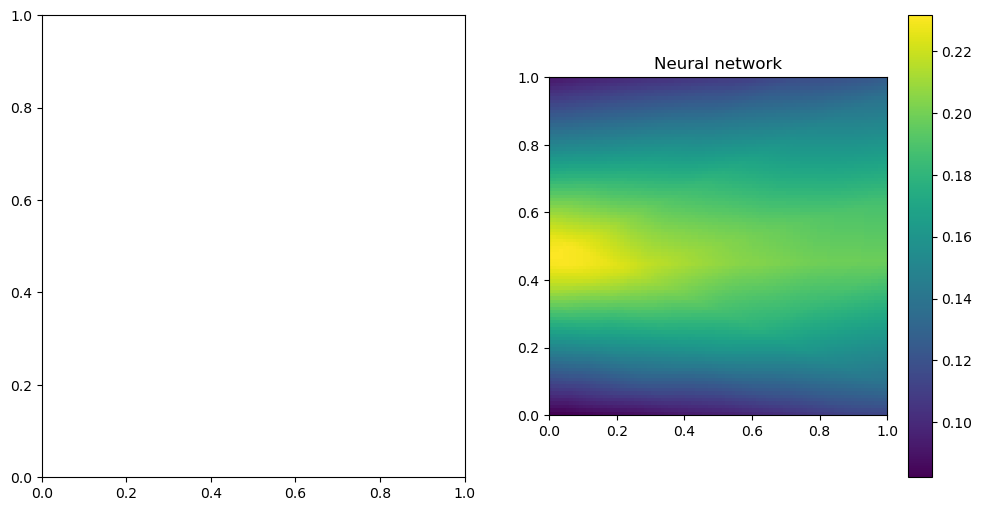

In [108]:
## This is a code to perform 2d regression using LBFGS
## Modify the code to solve the PDE 
## dz/dt = 0.05*d2z/dx2
## in the domain t = (0,1) and x = (0,1)
## The boundary conditions are z(x,0) = x*(1-x)

import torch
import matplotlib.pyplot as plt
from torch import nn, optim
import numpy as np

# Define the true function and generate some data
def true_func(model, input_data, xxx, ttt):

    # h = 0.001

    # xxh, tt = torch.meshgrid(xxx+h, ttt)
    # xh = torch.cat((xxh.reshape(-1, 1), tt.reshape(-1, 1)), 1)

    # xxmh, tt = torch.meshgrid(xxx-h, ttt)
    # xmh = torch.cat((xxmh.reshape(-1, 1), tt.reshape(-1, 1)), 1)

    # xx, th = torch.meshgrid(xxx, ttt+h)
    # th = torch.cat((xx.reshape(-1, 1), th.reshape(-1, 1)), 1)

    # dzdt = (model(th) - model(input_data))/h
    # # dzdx = (model(xh) - model(input_data))/h

    # d2zdx2 = (model(xh) - 2*model(input_data) + model(xmh))/(h*h)
    
    # same as above but with autograd
    m = model(input_data)
    grad = torch.autograd.grad(model(input_data), input_data, grad_outputs=torch.ones_like(m), create_graph=True)[0]
    
    dzdx = grad[:,0]
    dzdt = grad[:,1]
    d2zdx2 = torch.autograd.grad(dzdx, input_data, grad_outputs=torch.ones_like(dzdx), create_graph=True)[0][:,0]
    
    return dzdt - 0.05*d2zdx2



# Create a grid of points
x = torch.linspace(0, 1, 100)
t = torch.linspace(0, 1, 100)
xx, tt = torch.meshgrid(x, t)
# zz_true = true_func(xx, tt)

# Add some noise
# zz = zz_true

def BC(guess, x, t):
    # t0 = torch.cat((xx.reshape(-1, 1), torch.zeros_like(xx).reshape(-1, 1)), 1)
    t0 = guess.view_as(xx)[:,0]
    # print(t0.shape)
    return t0 - x*(1-x) # Boundary condition at t=0  <-  z(x,0) = x*(1-x)

# Convert to PyTorch tensors
input_data = torch.cat((xx.reshape(-1, 1), tt.reshape(-1, 1)), 1)
# target_data = zz.reshape(-1, 1)
input_data.requires_grad_(True)

# Define the neural network
model = nn.Sequential(
    nn.Linear(2, 100),
    nn.ReLU(),
    nn.Linear(100, 1),
)

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.LBFGS(model.parameters(), lr=0.1)

# Define a closure function for re-evaluation
def loss_fn(model):
    model.zero_grad()
    # optimizer.zero_grad()
    prediction = true_func(model, input_data, x, t)
    l1 = criterion(prediction, torch.zeros_like(prediction))
    bc = BC(model(input_data), x, t)
    l2 = criterion(bc, torch.zeros_like(bc))
    loss = l1 + l2/1.
    return loss

# Train the neural network
for step in range(1000):
    # loss=optimizer.step(lambda *args: loss_fn(model))
    loss = loss_fn(model)
    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= 1e-1*param.grad

    

    if(step%100==0):
      print(step," ",loss.item())

      


# Predict the function values at the grid points
with torch.no_grad():
    zz_pred = model(input_data).view_as(xx)

# Plot the true function and the neural network's approximation
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# c = axs[0].imshow(zz, origin='lower', extent=(-3, 3, -3, 3), cmap='viridis')
# fig.colorbar(c, ax=axs[0])
# axs[0].set_title('True function')

c = axs[1].imshow(zz_pred, origin='lower', extent=(0, 1, 0, 1), cmap='viridis')
fig.colorbar(c, ax=axs[1])
axs[1].set_title('Neural network')

plt.show()